In [80]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as mp
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

In [56]:

# Test Dataset imported
df = pd.read_csv('/Users/Nick/Downloads/bq-results-20230321-215404-1679435672783.csv', index_col=False)

#Data Cleaning
#Unneccessary columns removed
df = df.drop(columns=['date_AEST', 
                      'timestamp',
                      'tiemstamp_AEST',
                      'sessionID', 
                      'userID', 
                      'FTP', 
                      'weight',
                      'age',
                      'gender', 
                      'gps_accuracy',
                      'calories'
                      ])

#Empty rows removed
df = df.dropna()

#Removing zero data rows
df = df[(df.distance > 1) & (df.power > 1) & (df.enhanced_speed > 1)]

#Sample taken to improve model testing run time
df_sample = df.sample(frac=.1, replace=False, random_state=15)

#Index reset
df_sample = df_sample.reset_index(drop=True)

#Dataset standardisation required for clustering.
scaler = StandardScaler()
st_df = scaler.fit_transform(df_sample)

In [3]:
#Correlation analysis - showing no features are overly correlated
df.corr()

,distance,enhanced_altitude,ascent,grade,enhanced_speed,heart_rate,temperature,cadence,power
distance,1.000000,0.052603,0.728353,0.031873,0.006967,-0.125317,0.007729,0.066093,0.011137
enhanced_altitude,0.052603,1.000000,0.259187,0.163383,-0.130330,0.077212,-0.156586,0.026053,0.017377
ascent,0.728353,0.259187,1.000000,0.114053,-0.064556,0.004023,0.074439,0.057654,-0.001101
grade,0.031873,0.163383,0.114053,1.000000,-0.572718,0.072498,-0.017920,0.087271,0.284076
enhanced_speed,0.006967,-0.130330,-0.064556,-0.572718,1.000000,0.144062,-0.005821,0.318018,0.060911
heart_rate,-0.125317,0.077212,0.004023,0.072498,0.144062,1.000000,0.208237,0.230203,0.075552
temperature,0.007729,-0.156586,0.074439,-0.017920,-0.005821,0.208237,1.000000,0.080338,-0.021063
cadence,0.066093,0.026053,0.057654,0.087271,0.318018,0.230203,0.080338,1.000000,0.357353
power,0.011137,0.017377,-0.001101,0.284076,0.060911,0.075552,-0.021063,0.357353,1.000000


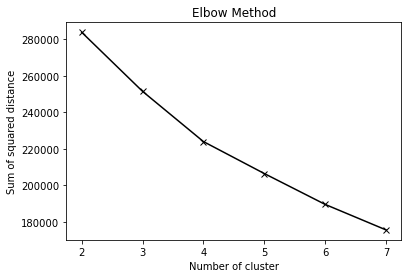

In [4]:
#Elbow Method
#Method of determining preferred number of clusters, based on diminishing sum of squares.
#Kmeans clustering model used for initial testing
totSqrdDist=[]
range_n_clusters = range(2,8)
for n_clusters in range_n_clusters:
    kmns= KMeans(n_clusters=n_clusters,  init='k-means++', n_init=10, random_state=10)
    kmns= kmns.fit(st_df)
    totSqrdDist.append(kmns.inertia_)
    
#Plots Sum of Squares for each cluster number
mp.plot(range_n_clusters,totSqrdDist,'-xk')
mp.title("Elbow Method", loc='center')
mp.ylabel('Sum of squared distance')
mp.xlabel('Number of cluster')
mp.show()

In [5]:
#Silhouette Scores
#Another method of determining number of clusters
#Measures how similar datapoints are in a cluster compared to other clusters

range_n_clusters = range(2,8)

for n_clusters in range_n_clusters:
    
    clusterer = KMeans(n_clusters=n_clusters,  init='k-means++', n_init=10, random_state=10)
    cluster_labels = clusterer.fit_predict(st_df)
    
    silhouette_avg = silhouette_score(st_df, cluster_labels)
    print("For n_clusters =", n_clusters,
    "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.26812453631770733
For n_clusters = 3 The average silhouette_score is : 0.16926903094118775
For n_clusters = 4 The average silhouette_score is : 0.19146693757153307
For n_clusters = 5 The average silhouette_score is : 0.2134303398234443
For n_clusters = 6 The average silhouette_score is : 0.1650988120538571
For n_clusters = 7 The average silhouette_score is : 0.16342617442020468


In [57]:
#Table representation of feature overlap across clusters.
#K-means Parameter loop
range_n_clusters = range(2,8)
    
for n_clusters in range_n_clusters: 
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=10)
    cluster_labels = clusterer.fit_predict(st_df)

    df_sample.insert(0, "Cluster", cluster_labels, True)

    #Data means/median/count
    print("Clusters = " + str(len(set(cluster_labels))))
    print("Distance")
    print(round(df_sample.groupby('Cluster')['distance'].describe(),2))
    print("Power")
    print(round(df_sample.groupby('Cluster')['power'].describe(),2))
    print("Speed")
    print(round(df_sample.groupby('Cluster')['enhanced_speed'].describe(),2))
    df_sample = df_sample.drop(columns=["Cluster"])

Clusters = 2
Distance
           count   mean    std  min    25%    50%    75%    max
Cluster                                                        
0         8506.0  46.74  25.24  1.0  26.69  44.18  62.70  120.9
1        28095.0  18.34  12.27  1.0   8.32  16.38  26.47   81.7
Power
           count    mean     std  min    25%    50%    75%     max
Cluster                                                           
0         8506.0  264.70  123.41  2.0  192.0  248.0  317.0  1180.0
1        28095.0  220.58  102.85  2.0  161.0  212.0  269.0  1017.0
Speed
           count   mean   std   min    25%    50%    75%    max
Cluster                                                        
0         8506.0  27.69  8.01  1.09  21.99  27.97  33.04  66.48
1        28095.0  32.46  6.62  2.33  28.81  32.51  36.27  71.72
Clusters = 3
Distance
           count   mean    std  min    25%    50%   75%     max
Cluster                                                        
0         6762.0  47.56  26.62  1.0 

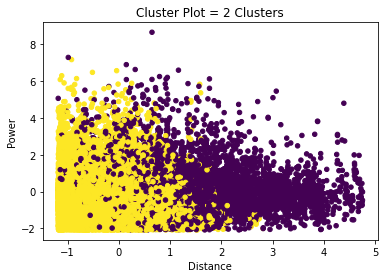

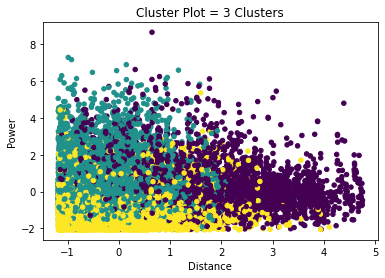

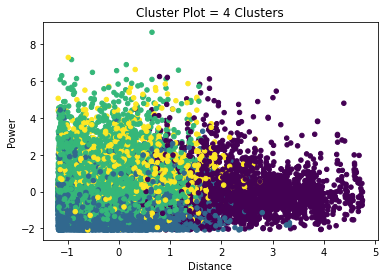

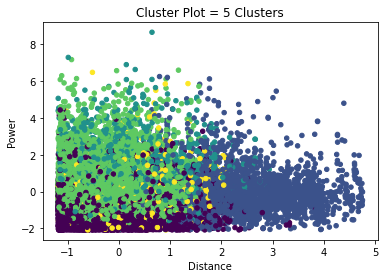

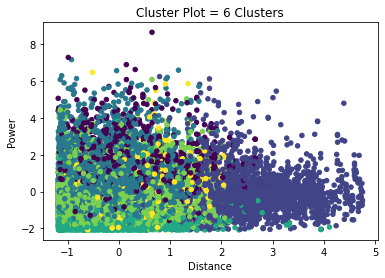

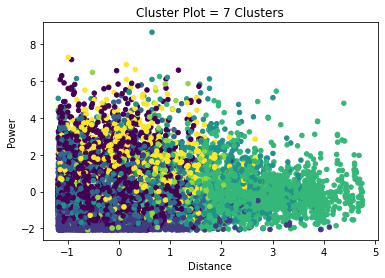

In [63]:
# Plot Clusters Example (Power v. Distance)
range_n_clusters = range(2,8)
    
for n_clusters in range_n_clusters: 
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=10)
    cluster_labels = clusterer.fit_predict(st_df)

    st_df_cl = pd.DataFrame(st_df, columns=df_sample.columns, index=df_sample.index)

    mp.scatter(st_df_cl['distance'], st_df_cl['power'], c=cluster_labels, s=20, cmap='viridis')
    mp.title("Cluster Plot = " + str(n_clusters) + " Clusters", loc='center')
    mp.xlabel("Distance")
    mp.ylabel("Power")
    mp.show()

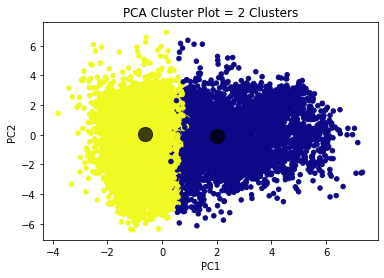

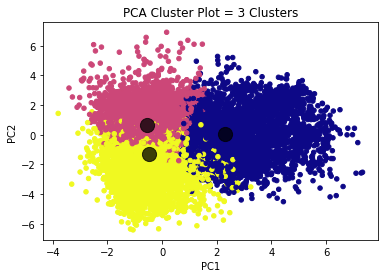

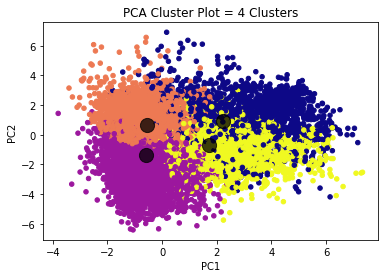

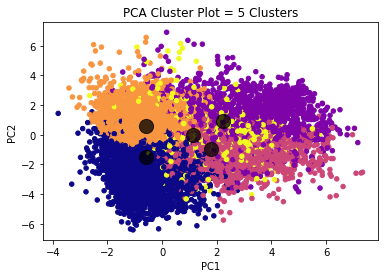

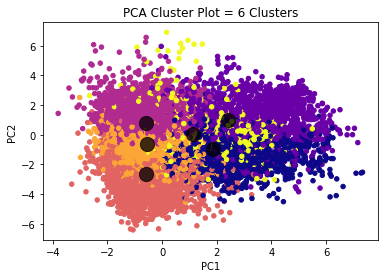

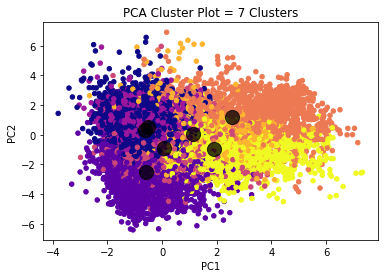

In [74]:
# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA(n_components=2)
pca.fit(st_df)

# Transfor the scaled data to the new PCA space
st_df_red = pca.transform(st_df)

# Plot Clusters Example (Power v. Distance)
range_n_clusters = range(2,8)
    
for n_clusters in range_n_clusters: 
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=10)
    cluster_labels = clusterer.fit_predict(st_df)

    df_red = pd.DataFrame(st_df_red, index=df_sample.index, columns=['PC1','PC2'])
    df_red['cluster'] = cluster_labels
    df_red_centre = pca.transform(clusterer.cluster_centers_)

    mp.scatter(df_red['PC1'], df_red['PC2'], c=cluster_labels, s=20, cmap='plasma')
    mp.title("PCA Cluster Plot = " + str(n_clusters) + " Clusters", loc='center')

    mp.scatter(df_red_centre[:, 0], df_red_centre[:, 1], c='black', s=200, alpha=0.75);
    mp.xlabel("PC1")
    mp.ylabel("PC2")
    mp.show()


### Kmodes

In [81]:
# Kmodes Silhouette Scores

range_n_clusters = range(2,8)

for n_clusters in range_n_clusters:
    
    kmodes = KModes(n_clusters=n_clusters, init='Huang', n_init=5, verbose=1, random_state=10)
    cluster_labels = kmodes.fit_predict(st_df)    
    
    silhouette_avg = silhouette_score(st_df, cluster_labels)
    print("For n_clusters =", n_clusters,
    "The average silhouette_score is :", silhouette_avg)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 801, cost: 292096.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 252, cost: 294497.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1152, cost: 292323.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 807, cost: 292149.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 17797, cost: 289815.0
Run 5, iteration: 2/100, moves: 278, cost: 289815.0
Best run was number 5
For n_clusters = 2 The average silhouette_score is : -0.03495976870442132
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 18968, cost: 285355.0
Run 1, iteration: 2/100, moves: 207, cost: 285355.0
Ini

#### Gaussian Mixture Model 

In [82]:
# Gaussian Silhouette Scores

range_n_clusters = range(2,8)

for n_clusters in range_n_clusters:
    
    gauss = GaussianMixture(n_components=n_clusters, random_state=10)
    cluster_labels = gauss.fit_predict(st_df)    
    
    silhouette_avg = silhouette_score(st_df, cluster_labels)
    print("For n_clusters =", n_clusters,
    "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.10581314731278453
For n_clusters = 3 The average silhouette_score is : 0.07839266766330542
For n_clusters = 4 The average silhouette_score is : 0.08892565678475423
For n_clusters = 5 The average silhouette_score is : 0.01727794833946576
For n_clusters = 6 The average silhouette_score is : 0.027465488509117852
For n_clusters = 7 The average silhouette_score is : 0.024016585427110958
